In [1]:
import nannyml as nml
import sklearn as sk
from sklearn import linear_model
from sklearn.datasets import make_classification
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm

In [2]:
reference, analysis, analysis_targets = nml.load_synthetic_car_loan_dataset()

In [3]:
# Join the analysis and analysis_targets into a single dataframe
analysis = analysis.join(analysis_targets)

In [4]:
# get rid of the timestap, y_pred_proba, and y_pred columns
reference = reference.drop(['timestamp', 'y_pred_proba', 'y_pred'], axis=1)
analysis = analysis.drop(['timestamp', 'y_pred_proba', 'y_pred'], axis=1)

In [5]:
# order the columns in the same way
analysis = analysis[reference.columns]
# make reference and analysis into one big dataframe
df = reference.append(analysis)

# splot the features from the label (repaid)
y = df['repaid']
X = df.drop(['repaid'], axis=1)

# convert the categorical features into one-hot encoded features
X = pd.get_dummies(X)

X.head()

/var/folders/kj/jqr6r99s1p945h2yplyzrglr0000gn/T/ipykernel_67060/954614719.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = reference.append(analysis)


,car_value,debt_to_income_ratio,loan_length,repaid_loan_on_prev_car,driver_tenure,salary_range_0 - 20K €,salary_range_20K - 20K €,salary_range_40K - 60K €,salary_range_60K+ €,size_of_downpayment_0%,size_of_downpayment_10%,size_of_downpayment_20%,size_of_downpayment_30%,size_of_downpayment_40%
0,39811.0,0.632950,19.0,False,0.212653,0,0,1,0,0,0,0,0,1
1,12679.0,0.718627,7.0,True,4.927549,0,0,1,0,0,1,0,0,0
2,19847.0,0.721724,17.0,False,0.520817,0,0,1,0,1,0,0,0,0
3,22652.0,0.705992,16.0,False,0.453649,0,1,0,0,0,1,0,0,0
4,21268.0,0.671888,21.0,True,5.695263,0,0,0,1,0,0,0,1,0


In [6]:
class Voter:
    def __init__(self, model, id):
        self.model = model
        self.id = id
        self.accuracy = []
        self.batch_accuracies = []
        self.CI = (0,0)
        
    def partial_fit(self, X, y):
        self.model.partial_fit(X, y)
    
    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions
    
class DelegationMechanism:
    def __init__(self):
        self.delegations = {}  # key: delegate_from (id), value: delegate_to (id)
        
    def delegate(self, from_id, to_id):
        #cycles are impossible with this mechanism, so we don't need to check for them
        self.delegations[from_id] = to_id

    def wilson_score_interval(self, point_wise_accuracies, confidence = 0.95):
        
        ups = sum(point_wise_accuracies)
        downs = len(point_wise_accuracies) - ups
        n = len(point_wise_accuracies)

        #use the specified confidence value to calculate the z-score
        z = stats.norm.ppf(1 - (1 - confidence) / 2)
        p = ups / n

        left = p + 1/(2*n)*z*z
        right = z*np.sqrt(p*(1-p)/n + z*z/(4*n*n))
        under = 1+1/n*z*z

        return ((left - right)/under, (left + right)/under)


    def calculate_CI(self, voter):
        point_wise_accuracies = voter.accuracy

        # assume the point wise accuracies are a list of bernoulli random variables
        # approximate using the Wilson score interval
        return self.wilson_score_interval(point_wise_accuracies)

    def update_delegations(self, voters):    
        #first, we need to recalculate the CI for each voter
        for voter in voters:
            voter.CI = self.calculate_CI(voter)

        #now we need to do two things:
        #1. ensure all current delegations are still valid. If not, remove them
        #2. go through the full delegation process
        delegators_to_pop = []
        for delegator, delegee in self.delegations.items(): #check delegations and break invalid ones
            if delegator.CI[1] > delegee.CI[0]:
                delegators_to_pop.append(delegator)
        for delegator in delegators_to_pop:
            self.delegations.pop(delegator)
        
        for voter in voters: #go through the full delegation process
            possible_delegees = []
            gaps = []
            for other_voter in voters:
                # find all voters who are SIGNIFICANTLY better than the current voter. TODO: Could possibly apply a penalty for a high number of delegations
                if other_voter.id != voter.id and (other_voter.CI[0] > voter.CI[1]):
                    possible_delegees.append(other_voter)
                    gaps.append(other_voter.CI[0] - voter.CI[1])
            if len(possible_delegees) > 0:
                #probabilistically delegate based on the gaps
                # larger gaps are more likely to be chosen
                sum_gaps = sum(gaps)
                probabilities = [gap/sum_gaps for gap in gaps]
                delegee = np.random.choice(possible_delegees, p=probabilities)
                self.delegate(voter, delegee)

    def get_gurus(self, voters):
        #find all voters who have not delegated to anyone
        gurus = []
        for voter in voters:
            if voter.id not in self.delegations.keys():
                gurus.append(voter)
        return gurus

In [13]:
n_voters = 100
voters = []

for i in range(n_voters):
    voters.append(Voter(linear_model.SGDClassifier(), i))

delegation_mechanism = DelegationMechanism()

# full ensemble clf not using the voters
full_ensemble_models = [linear_model.SGDClassifier() for i in range(n_voters)]

#reshape y to be a 2d array
classes = np.unique(y)

batch_size = 500

lDem_accs = []
full_ensemble_accs = []

for i in tqdm(range(0, len(X), batch_size)):
    X_batch = X[i:i+batch_size].values
    y_batch = y[i:i+batch_size].values
    

    if i == 0:
        print("initial fit")
        for voter in voters:
            voter.model.partial_fit(X_batch, y_batch, classes=np.unique(y))

        for model in full_ensemble_models:
            model.partial_fit(X_batch, y_batch, classes=np.unique(y))

    else:
        gurus = delegation_mechanism.get_gurus(voters)
        for guru in gurus: # each guru predicts the batch
            #make predictions on the batch
            predictions = guru.predict(X_batch)
            #we will log the performance of the guru for each data point in the batch
            for j in range(len(predictions)):
                point_wise_accuracy = [1 if predictions[j] == y_batch[j] else 0]
                guru.accuracy.extend(point_wise_accuracy)
            #we will also log the batch accuracy
            guru.batch_accuracies.append(sum(point_wise_accuracy)/len(point_wise_accuracy))

        # make
        ensemble_preds = [np.argmax(np.bincount([guru.predict(X_batch[i].reshape(1, -1))[0] for guru in gurus])) for i in range(len(X_batch))]
        #calculate the accuracy of the ensemble using np.mean
        ensemble_accuracy = np.mean(ensemble_preds == y_batch)
        lDem_accs.append(ensemble_accuracy)

        # make a prediction with the full ensemble
        full_ensemble_preds = [np.argmax(np.bincount([model.predict(X_batch[i].reshape(1, -1))[0] for model in full_ensemble_models])) for i in range(len(X_batch))]
        #calculate the accuracy of the ensemble using np.mean
        full_ensemble_accuracy = np.mean(full_ensemble_preds == y_batch)
        full_ensemble_accs.append(full_ensemble_accuracy)

        delegation_mechanism.update_delegations(voters) # update delegations based on the new accuracies

        gurus = delegation_mechanism.get_gurus(voters) # fit the new gurus on the batch
        for guru in gurus:
            guru.model.partial_fit(X_batch, y_batch)

        for model in full_ensemble_models:
            model.partial_fit(X_batch, y_batch)

print(lDem_accs)
print(full_ensemble_accs)
    

  0%|          | 0/200 [00:00<?, ?it/s]

initial fit


100%|██████████| 200/200 [52:11<00:00, 15.66s/it]

[0.498, 0.524, 0.482, 0.5, 0.476, 0.44, 0.464, 0.528, 0.526, 0.498, 0.51, 0.498, 0.524, 0.512, 0.498, 0.448, 0.532, 0.504, 0.47, 0.478, 0.484, 0.48, 0.476, 0.5, 0.526, 0.494, 0.492, 0.488, 0.532, 0.502, 0.502, 0.482, 0.494, 0.512, 0.538, 0.486, 0.498, 0.516, 0.454, 0.468, 0.48, 0.46, 0.482, 0.528, 0.486, 0.506, 0.512, 0.534, 0.484, 0.506, 0.534, 0.544, 0.49, 0.476, 0.484, 0.508, 0.498, 0.494, 0.462, 0.532, 0.514, 0.488, 0.506, 0.516, 0.558, 0.48, 0.518, 0.53, 0.526, 0.542, 0.452, 0.464, 0.486, 0.5, 0.518, 0.522, 0.534, 0.492, 0.498, 0.504, 0.534, 0.502, 0.532, 0.5, 0.51, 0.526, 0.516, 0.518, 0.48, 0.492, 0.45, 0.518, 0.522, 0.514, 0.48, 0.504, 0.502, 0.452, 0.49, 0.518, 0.472, 0.462, 0.514, 0.53, 0.436, 0.504, 0.504, 0.492, 0.48, 0.492, 0.49, 0.524, 0.478, 0.492, 0.456, 0.508, 0.506, 0.49, 0.484, 0.484, 0.526, 0.54, 0.472, 0.488, 0.472, 0.524, 0.51, 0.498, 0.516, 0.5, 0.526, 0.494, 0.488, 0.528, 0.496, 0.512, 0.494, 0.516, 0.474, 0.452, 0.476, 0.504, 0.468, 0.502, 0.472, 0.508, 0.47, 0

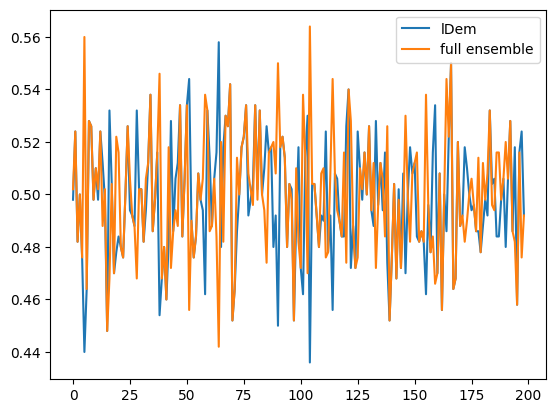

In [14]:
# plot the accuracies of the ensemble and the full ensemble
import matplotlib.pyplot as plt
plt.plot(lDem_accs, label="lDem")
plt.plot(full_ensemble_accs, label="full ensemble")
plt.legend()
plt.show()

In [15]:
print("delegations", len(delegation_mechanism.delegations))

delegations 2


## TODO
- Train full classifier on all data to see if it will actually learn something
  - If it does, why dont the ensembles learn?
- If not learning, make simple gaussian datasets
- try using selecting which data distribution to use as X. Change over time
- Try using a mixture of two distrubtions in a single batch
- Keep track of how "fit" the classifiers are
  - i.e. where the shift happens (after 500 exmamples vs 10000000000 examples)
- Keep track of confidence interval size
- If the setting is cyclical then we may not want the gurus from dist 1 to learn or be active on dist 2